<a href="https://colab.research.google.com/github/james-mugabo/narrative-flow-analysis/blob/main/Cross_Platform_Narrative_Flow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install feedparser scikit-learn pandas matplotlib seaborn

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.5/81.5 kB 4.0 MB/s eta 0:00:00
  Created wheel for sgmllib3k: filename=sgmllib3k-1.0.0-py3-none-any.whl size=6046 sha256=781ae75a5ad7694115f3151bb2d377d95f2f66fb2dc5deecfdae447f52621272
  Stored in directory: /root/.cache/pip/wheels/03/f5/1a/23761066dac1d0e8e683e5fdb27e12de53209d05a4a37e6246
Successfully built sgmllib3k


--- Starting Narrative Flow Analysis for: Artificial Intelligence ---
Fetching News RSS...
Fetching Reddit Comments...


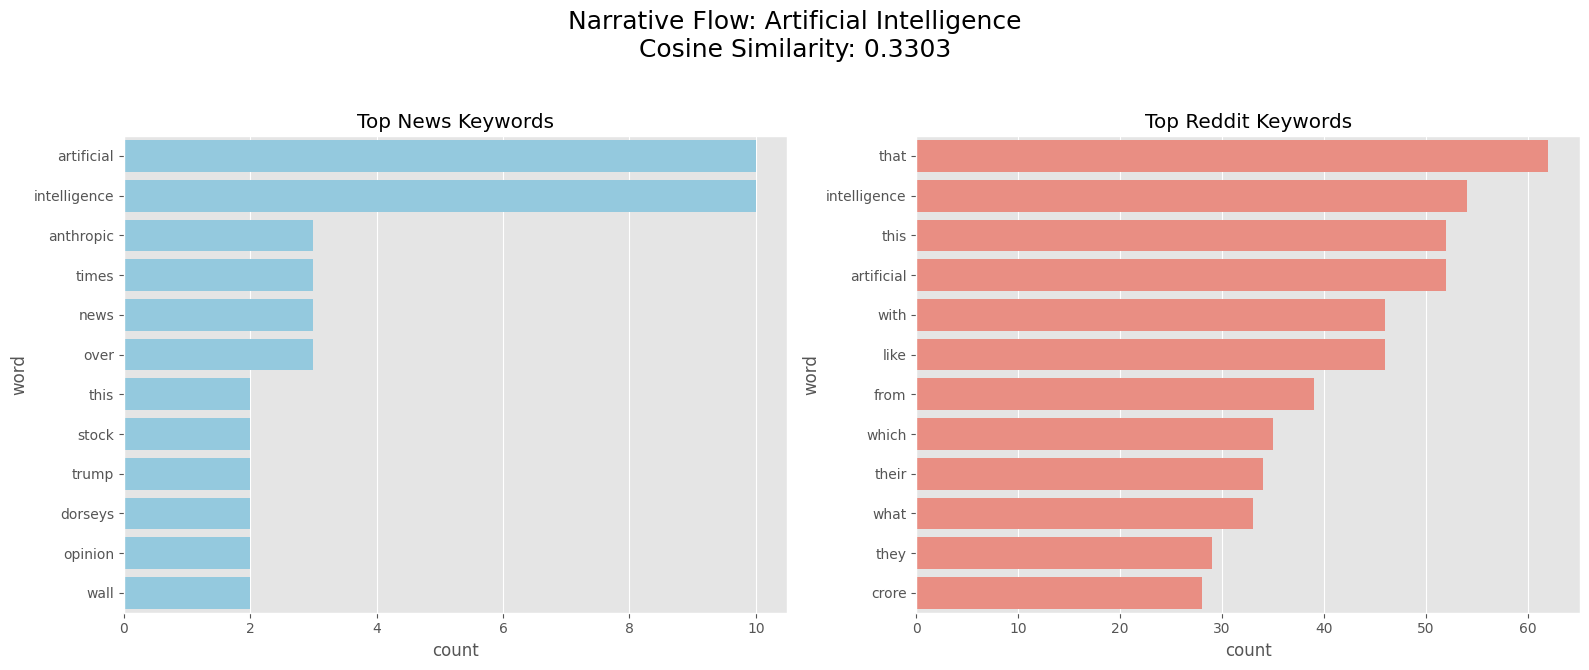


Analysis Complete.
Narrative Alignment: 33.03%


In [1]:
# 1. INSTALL DEPENDENCIES (Safe for fresh Colab sessions)
import sys
import subprocess

def install(package):
    subprocess.check_call([sys.executable, "-m", "pip", "install", package])

try:
    import feedparser
except ImportError:
    install('feedparser')
    import feedparser

import requests
import pandas as pd
import re
import urllib.parse
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from collections import Counter

# --- 2. CONFIGURATION & URL ENCODING ---
TOPIC_QUERY = "Artificial Intelligence"  # Change this to any topic!
encoded_query = urllib.parse.quote(TOPIC_QUERY)

# Build the encoded URLs
RSS_URL = f"https://news.google.com/rss/search?q={encoded_query}"
REDDIT_URL = "https://api.pullpush.io/reddit/search/comment/"

def clean_text(text):
    """Removes special characters and lowercases text."""
    return re.sub(r'[^\w\s]', '', str(text)).lower()

# --- 3. DATA COLLECTION ---
print(f"--- Starting Narrative Flow Analysis for: {TOPIC_QUERY} ---")

# News Collection
print("Fetching News RSS...")
news_feed = feedparser.parse(RSS_URL)
news_titles = [entry.title for entry in news_feed.entries[:20]]
news_clean = [clean_text(t) for t in news_titles]

# Reddit Collection (Using 'params' to auto-encode query)
print("Fetching Reddit Comments...")
try:
    params = {'q': TOPIC_QUERY, 'size': 50}
    response = requests.get(REDDIT_URL, params=params, timeout=15)
    response.raise_for_status()
    raw_data = response.json().get('data', [])
    reddit_clean = [clean_text(post.get('body', '')) for post in raw_data if post.get('body')]
except Exception as e:
    print(f"Reddit Error: {e}")
    reddit_clean = []

# --- 4. ANALYTICS & VISUALIZATION ---
if len(news_clean) > 0 and len(reddit_clean) > 0:
    # Vectorization
    vectorizer = TfidfVectorizer(stop_words='english')
    corpus = [" ".join(news_clean), " ".join(reddit_clean)]
    tfidf_matrix = vectorizer.fit_transform(corpus)

    # Calculate Similarity Score
    similarity = cosine_similarity(tfidf_matrix[0:1], tfidf_matrix[1:2])[0][0]

    # Word Frequency for Charts
    def get_top_words(text_list, n=12):
        words = " ".join(text_list).split()
        words = [w for w in words if len(w) > 3] # Filter out short words
        return Counter(words).most_common(n)

    news_df = pd.DataFrame(get_top_words(news_clean), columns=['word', 'count'])
    reddit_df = pd.DataFrame(get_top_words(reddit_clean), columns=['word', 'count'])

    # Plotting
    plt.style.use('ggplot')
    fig, axes = plt.subplots(1, 2, figsize=(16, 7))
    fig.suptitle(f"Narrative Flow: {TOPIC_QUERY}\nCosine Similarity: {similarity:.4f}", fontsize=18)

    sns.barplot(x='count', y='word', data=news_df, ax=axes[0], color='skyblue').set_title("Top News Keywords")
    sns.barplot(x='count', y='word', data=reddit_df, ax=axes[1], color='salmon').set_title("Top Reddit Keywords")

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    print(f"\nAnalysis Complete.")
    print(f"Narrative Alignment: {round(similarity * 100, 2)}%")
else:
    print("\n[!] Error: Could not retrieve enough data from one or both sources.")

Cosine Similarity
Cos(θ) = (A.B)/(||A|| ||B||)

Now let's go ahead and and use VADER for sentiment analysis. VADER (Valence Aware Dictionary and sEntiment Reasoner)

/tmp/ipython-input-583/3263778563.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=averages, palette=colors)


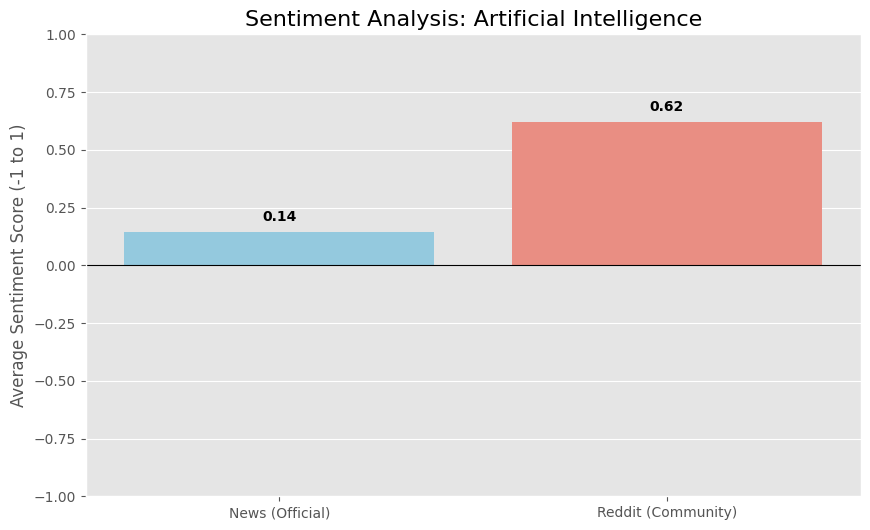


--- SENTIMENT REPORT ---
News Sentiment: 0.1420
Reddit Sentiment: 0.6194
Divergence Alert: There is a significant emotional gap (0.48) between the sources.


In [2]:
# 1. INSTALL NLTK FOR SENTIMENT
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon', quiet=True)

# Initialize the Sentiment Analyzer
sia = SentimentIntensityAnalyzer()

def get_sentiment_stats(corpus_list):
    """Calculates average sentiment scores for a list of strings."""
    scores = [sia.polarity_scores(text)['compound'] for text in corpus_list]
    avg_score = sum(scores) / len(scores) if scores else 0
    return avg_score, scores

# --- DATA PROCESSING ---
news_avg, news_raw_scores = get_sentiment_stats(news_clean)
reddit_avg, reddit_raw_scores = get_sentiment_stats(reddit_clean)

# --- VISUALIZATION ---
plt.figure(figsize=(10, 6))
labels = ['News (Official)', 'Reddit (Community)']
averages = [news_avg, reddit_avg]
colors = ['skyblue', 'salmon']

sns.barplot(x=labels, y=averages, palette=colors)
plt.axhline(0, color='black', linewidth=0.8) # Baseline for neutral
plt.title(f"Sentiment Analysis: {TOPIC_QUERY}", fontsize=16)
plt.ylabel("Average Sentiment Score (-1 to 1)")
plt.ylim(-1, 1)

# Add value labels on top of bars
for i, v in enumerate(averages):
    plt.text(i, v + (0.05 if v > 0 else -0.1), f"{v:.2f}", ha='center', fontweight='bold')

plt.show()

# --- SUMMARY REPORT ---
print(f"\n--- SENTIMENT REPORT ---")
print(f"News Sentiment: {news_avg:.4f}")
print(f"Reddit Sentiment: {reddit_avg:.4f}")

gap = abs(news_avg - reddit_avg)
if gap > 0.2:
    print(f"Divergence Alert: There is a significant emotional gap ({gap:.2f}) between the sources.")
else:
    print("Alignment: The emotional tone is relatively similar across platforms.")

/tmp/ipython-input-583/2717419361.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['News', 'Reddit'], y=[news_sent, reddit_sent], palette=['skyblue', 'salmon'], ax=axes[1, 0])


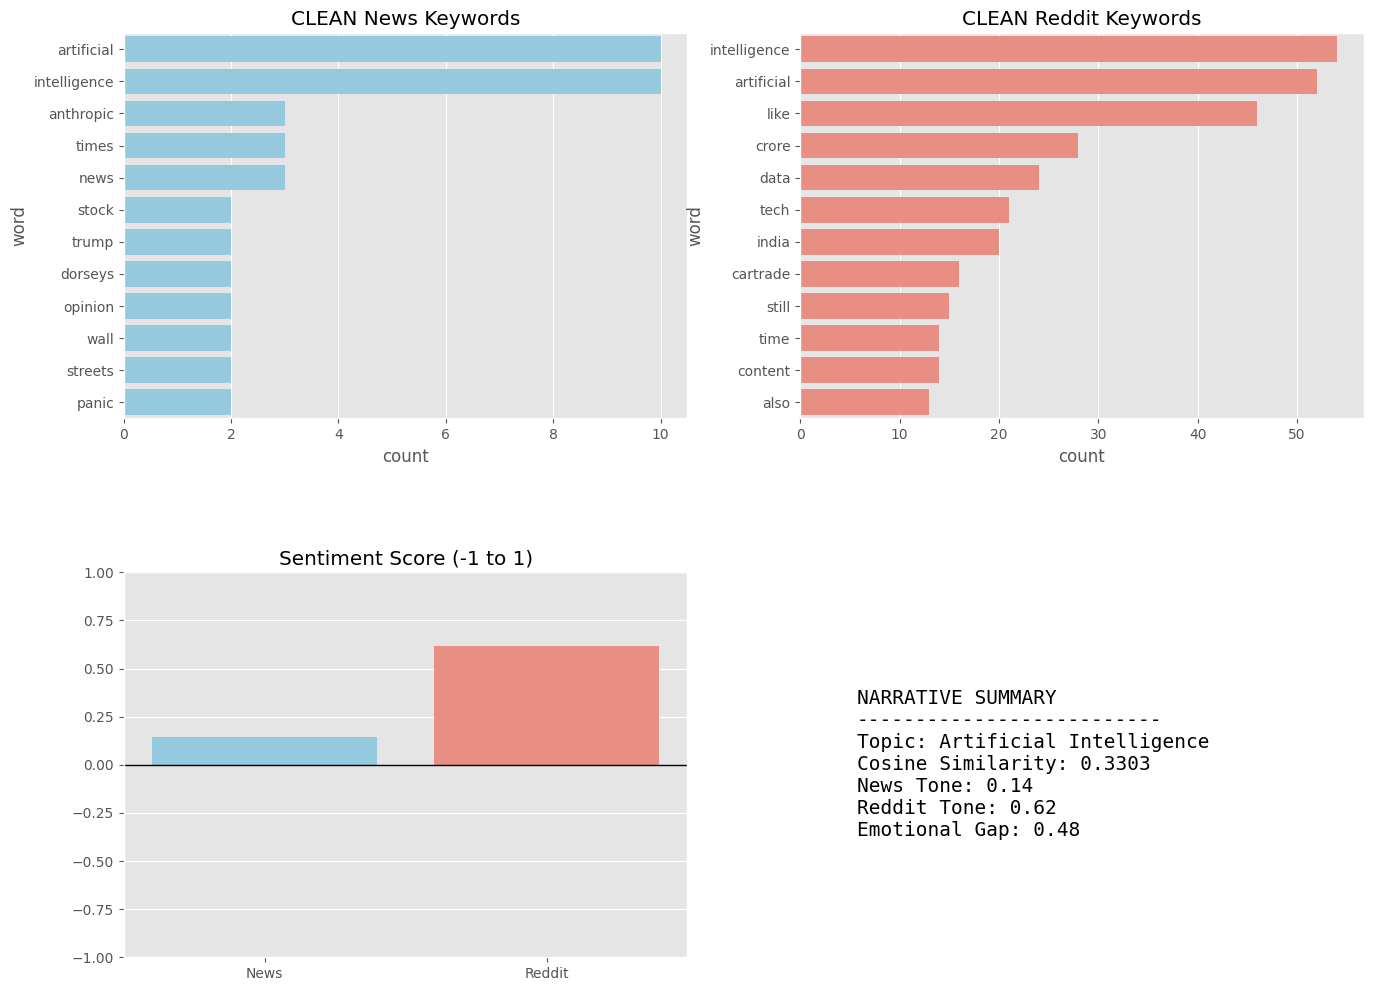

In [3]:
import nltk
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# 1. SETUP: Download cleaning tools
nltk.download('stopwords', quiet=True)
nltk.download('vader_lexicon', quiet=True)

stop_words = set(stopwords.words('english'))
# Adding a few extra custom "noise" words common in these APIs
stop_words.update(['that', 'this', 'with', 'from', 'which', 'their', 'what', 'they', 'would', 'could', 'about'])

sia = SentimentIntensityAnalyzer()

# 2. BETTER WORD FILTERING
def get_meaningful_words(text_list, n=12):
    all_words = " ".join(text_list).split()
    # Filter: Must be > 3 chars, not a stop word, and alphabetical
    meaningful = [w for w in all_words if len(w) > 3 and w not in stop_words and w.isalpha()]
    return Counter(meaningful).most_common(n)

# 3. ANALYTICS
news_top = get_meaningful_words(news_clean)
reddit_top = get_meaningful_words(reddit_clean)

# Calculate Sentiment
news_sent = sum([sia.polarity_scores(t)['compound'] for t in news_clean]) / len(news_clean)
reddit_sent = sum([sia.polarity_scores(t)['compound'] for t in reddit_clean]) / len(reddit_clean)

# 4. DATA VISUALIZATION
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
plt.subplots_adjust(hspace=0.4)

# Top Left: News Keywords
news_df = pd.DataFrame(news_top, columns=['word', 'count'])
sns.barplot(x='count', y='word', data=news_df, ax=axes[0, 0], color='skyblue').set_title("CLEAN News Keywords")

# Top Right: Reddit Keywords
reddit_df = pd.DataFrame(reddit_top, columns=['word', 'count'])
sns.barplot(x='count', y='word', data=reddit_df, ax=axes[0, 1], color='salmon').set_title("CLEAN Reddit Keywords")

# Bottom: Sentiment Comparison
sns.barplot(x=['News', 'Reddit'], y=[news_sent, reddit_sent], palette=['skyblue', 'salmon'], ax=axes[1, 0])
axes[1, 0].set_title("Sentiment Score (-1 to 1)")
axes[1, 0].set_ylim(-1, 1)
axes[1, 0].axhline(0, color='black', lw=1)

# Bottom Right: Narrative Metrics Summary
axes[1, 1].axis('off')
summary_text = (
    f"NARRATIVE SUMMARY\n"
    f"--------------------------\n"
    f"Topic: {TOPIC_QUERY}\n"
    f"Cosine Similarity: {similarity:.4f}\n"
    f"News Tone: {news_sent:.2f}\n"
    f"Reddit Tone: {reddit_sent:.2f}\n"
    f"Emotional Gap: {abs(news_sent - reddit_sent):.2f}"
)
axes[1, 1].text(0.1, 0.5, summary_text, fontsize=14, family='monospace', verticalalignment='center')

plt.show()

Named Entity Recognition using spaCy

In [4]:
import spacy
from spacy import displacy

# Load the small English model (fast and efficient for Colab)
try:
    nlp = spacy.load("en_core_web_sm")
except:
    !python -m spacy download en_core_web_sm
    nlp = spacy.load("en_core_web_sm")

Extracting entities from News...
Extracting entities from Reddit...


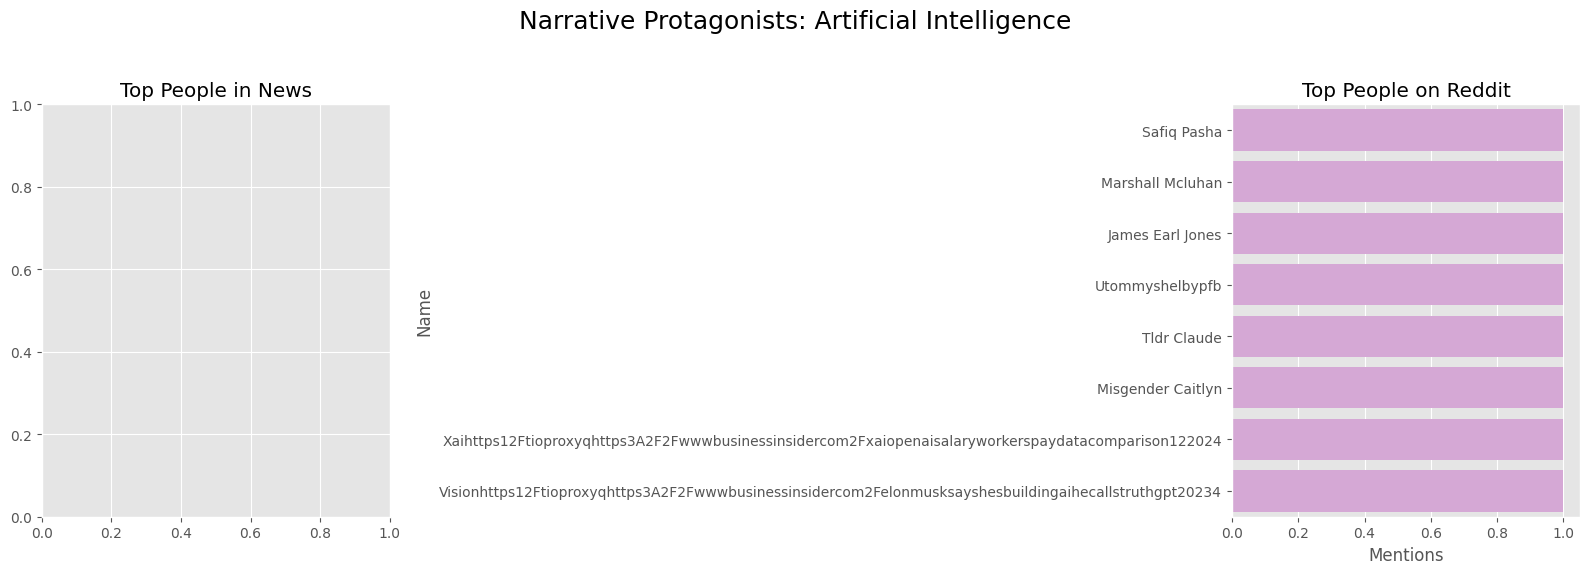


--- ENTITY SYNC REPORT ---
Entities unique to News: 9
Entities unique to Reddit: 15
Shared Entities (The Narrative Core): None


In [5]:
def extract_entities(text_list):
    entities = {"PERSON": [], "ORG": [], "GPE": []}
    full_text = " ".join(text_list)
    doc = nlp(full_text)

    for ent in doc.ents:
        if ent.label_ in entities:
            # Clean up the entity name
            clean_ent = ent.text.strip().title()
            if len(clean_ent) > 2: # Ignore noise
                entities[ent.label_].append(clean_ent)
    return entities

# --- 1. PROCESS ENTITIES ---
print("Extracting entities from News...")
news_entities = extract_entities(news_clean)

print("Extracting entities from Reddit...")
reddit_entities = extract_entities(reddit_clean)

# --- 2. COMPARE TOP PEOPLE ---
news_people = Counter(news_entities["PERSON"]).most_common(8)
reddit_people = Counter(reddit_entities["PERSON"]).most_common(8)

# --- 3. VISUALIZATION ---
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle(f"Narrative Protagonists: {TOPIC_QUERY}", fontsize=18)

# News People Bar
news_p_df = pd.DataFrame(news_people, columns=['Name', 'Mentions'])
sns.barplot(x='Mentions', y='Name', data=news_p_df, ax=axes[0], color='lightgreen').set_title("Top People in News")

# Reddit People Bar
reddit_p_df = pd.DataFrame(reddit_people, columns=['Name', 'Mentions'])
sns.barplot(x='Mentions', y='Name', data=reddit_p_df, ax=axes[1], color='plum').set_title("Top People on Reddit")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# --- 4. ENTITY OVERLAP CALCULATION ---
news_set = set(news_entities["PERSON"] + news_entities["ORG"])
reddit_set = set(reddit_entities["PERSON"] + reddit_entities["ORG"])
shared_entities = news_set.intersection(reddit_set)

print(f"\n--- ENTITY SYNC REPORT ---")
print(f"Entities unique to News: {len(news_set - reddit_set)}")
print(f"Entities unique to Reddit: {len(reddit_set - news_set)}")
print(f"Shared Entities (The Narrative Core): {list(shared_entities)[:5] if shared_entities else 'None'}")

Narrative gap table (even though there is no overlap)


--- THE NARRATIVE GAP: ENTITY COMPARISON ---
Platform             Entity  Mentions  Sentiment
    NEWS                Bbc         1     0.0000
    NEWS The New York Times         1     0.5994
    NEWS           Pentagon         1     0.0000
    NEWS               Cnbc         1     0.0000
    NEWS           Cbs News         1    -0.4215
  REDDIT                Fda         2     0.9298
  REDDIT               Gero         2     0.8360
  REDDIT                Tvs         2     0.9991
  REDDIT        Safiq Pasha         1     0.4019
  REDDIT   Marshall Mcluhan         1     0.9233


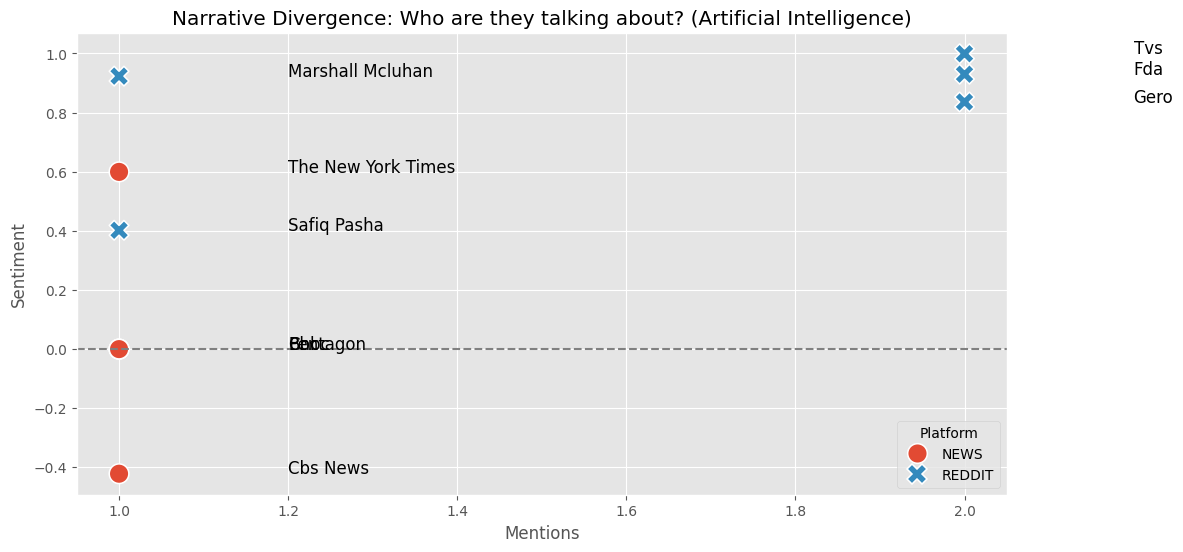

In [6]:
# 1. HELPER: Sentiment for specific entities
def get_entity_context_sentiment(text_list, entity_name):
    """Finds sentences containing the entity and averages their sentiment."""
    relevant_sentences = [s for s in text_list if entity_name.lower() in s.lower()]
    if not relevant_sentences: return 0

    scores = [sia.polarity_scores(s)['compound'] for s in relevant_sentences]
    return sum(scores) / len(scores)

# 2. PREP DATA
news_top_entities = Counter(news_entities["PERSON"] + news_entities["ORG"]).most_common(5)
reddit_top_entities = Counter(reddit_entities["PERSON"] + reddit_entities["ORG"]).most_common(5)

data = []

# Process News Entities
for ent, count in news_top_entities:
    sent = get_entity_context_sentiment(news_clean, ent)
    data.append({"Platform": "NEWS", "Entity": ent, "Mentions": count, "Sentiment": sent})

# Process Reddit Entities
for ent, count in reddit_top_entities:
    sent = get_entity_context_sentiment(reddit_clean, ent)
    data.append({"Platform": "REDDIT", "Entity": ent, "Mentions": count, "Sentiment": sent})

# 3. DISPLAY AS TABLE
df_gap = pd.DataFrame(data)
print("\n--- THE NARRATIVE GAP: ENTITY COMPARISON ---")
print(df_gap.to_string(index=False))

# 4. VISUALIZE THE DISCONNECT
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df_gap, x="Mentions", y="Sentiment", hue="Platform", style="Platform", s=200)

# Label the points
for i in range(df_gap.shape[0]):
    plt.text(df_gap.Mentions[i]+0.2, df_gap.Sentiment[i], df_gap.Entity[i], fontsize=12)

plt.axhline(0, color='grey', linestyle='--')
plt.title(f"Narrative Divergence: Who are they talking about? ({TOPIC_QUERY})")
plt.show()

In [7]:
from sklearn.decomposition import LatentDirichletAllocation

def get_top_topics(text_list, n_topics=3, n_words=5):
    if not text_list: return []

    # Vectorize the text for the model
    vec = TfidfVectorizer(stop_words='english', max_features=500)
    matrix = vec.fit_transform(text_list)

    # Run the LDA Model
    lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
    lda.fit(matrix)

    # Extract the words for each topic
    feature_names = vec.get_feature_names_out()
    topics = []
    for idx, topic in enumerate(lda.components_):
        top_words = [feature_names[i] for i in topic.argsort()[:-n_words - 1:-1]]
        topics.append(f"Theme {idx+1}: " + ", ".join(top_words))
    return topics

# --- 2. EXECUTION ---
print(f"--- THEME DISCOVERY: {TOPIC_QUERY} ---")

print("\nNEWS TOPICS (The Professional Narrative):")
news_themes = get_top_topics(news_clean)
for t in news_themes: print(f" - {t}")

print("\nREDDIT TOPICS (The Community Narrative):")
reddit_themes = get_top_topics(reddit_clean)
for t in reddit_themes: print(f" - {t}")

--- THEME DISCOVERY: Artificial Intelligence ---

NEWS TOPICS (The Professional Narrative):
 - Theme 1: artificial, intelligence, opinion, faculty, data
 - Theme 2: ai, artificial, intelligence, times, inner
 - Theme 3: ai, trump, anthropic, foushee, texas

REDDIT TOPICS (The Community Narrative):
 - Theme 1: ai, people, intelligence, artificial, learning
 - Theme 2: data, takes, crore, using, delivery
 - Theme 3: artificial, intelligence, ai, gt, like


Conclusion: While the narrative similarity is low (0.33), both platforms exhibit positive sentiment, though they focus on entirely different spheres of the ecosystem (Institutional vs. Functional).

Let's now apply analyze a different set of topics: high_variance_topics = [
    "ai related layoffs",
    "universal basic income",
    "nuclear energy",
    "cryptocurrency regulation",
    "social media ban"
]

In [8]:
# 1. SETUP & INSTALLATION
import sys
import subprocess
import urllib.parse
import time
import re
import requests
import feedparser
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# NLP & Math Libraries
try:
    import spacy
    from nltk.sentiment.vader import SentimentIntensityAnalyzer
    from sklearn.feature_extraction.text import TfidfVectorizer
    from sklearn.metrics.pairwise import cosine_similarity
    from sklearn.decomposition import LatentDirichletAllocation
    import nltk
except ImportError:
    !pip install spacy feedparser scikit-learn nltk
    import spacy
    from nltk.sentiment.vader import SentimentIntensityAnalyzer
    # ... (re-importing after install)

# Initialize NLP models
nltk.download('vader_lexicon', quiet=True)
nltk.download('stopwords', quiet=True)
sia = SentimentIntensityAnalyzer()
try:
    nlp = spacy.load("en_core_web_sm")
except:
    subprocess.check_call([sys.executable, "-m", "spacy", "download", "en_core_web_sm"])
    nlp = spacy.load("en_core_web_sm")

from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

# --- HELPER FUNCTIONS ---

def clean_text(text):
    return re.sub(r'[^\w\s]', '', str(text)).lower()

def get_dominant_theme(text_list):
    if not text_list: return "No data"
    vec = TfidfVectorizer(stop_words='english', max_features=100)
    matrix = vec.fit_transform(text_list)
    lda = LatentDirichletAllocation(n_components=1, random_state=42)
    lda.fit(matrix)
    words = vec.get_feature_names_out()
    return ", ".join([words[i] for i in lda.components_[0].argsort()[-5:]])

def extract_top_entities(text_list):
    full_text = " ".join(text_list)
    doc = nlp(full_text[:1000000]) # Limit for performance
    entities = [ent.text.strip().title() for ent in doc.ents if ent.label_ in ["PERSON", "ORG"]]
    return [e for e, c in Counter(entities).most_common(3)]

# --- THE MASTER ANALYSIS FUNCTION ---

def run_sentiment_analysis(topic):
    print(f"\n{'='*70}")
    print(f" RESEARCH TOPIC: {topic.upper()}")
    print(f"{'='*70}")

    # 1. DATA COLLECTION
    encoded_q = urllib.parse.quote(topic)
    news_url = f"https://news.google.com/rss/search?q={encoded_q}"
    reddit_url = "https://api.pullpush.io/reddit/search/comment/"

    # Fetch News
    n_feed = feedparser.parse(news_url)
    n_raw = [clean_text(e.title) for e in n_feed.entries[:15]]

    # Fetch Reddit
    try:
        r_resp = requests.get(reddit_url, params={'q': topic, 'size': 50}, timeout=10)
        r_data = r_resp.json().get('data', [])
        r_raw = [clean_text(p.get('body', '')) for p in r_data if p.get('body')]
    except Exception as e:
        print(f"API Error: {e}")
        r_raw = []

    if not n_raw or not r_raw:
        print(f"[!] Insufficient data for '{topic}'. Moving to next...")
        return

    # 2. CALCULATE METRICS
    # Linguistic Similarity
    vec = TfidfVectorizer(stop_words='english')
    tfidf = vec.fit_transform([" ".join(n_raw), " ".join(r_raw)])
    sim = cosine_similarity(tfidf[0:1], tfidf[1:2])[0][0]

    # Sentiment
    n_sents = [sia.polarity_scores(t)['compound'] for t in n_raw]
    r_sents = [sia.polarity_scores(t)['compound'] for t in r_raw]
    n_avg, r_avg = sum(n_sents)/len(n_sents), sum(r_sents)/len(r_sents)

    # Themes & Entities
    n_theme = get_dominant_theme(n_raw)
    r_theme = get_dominant_theme(r_raw)
    n_ents = extract_top_entities(n_raw)
    r_ents = extract_top_entities(r_raw)

    # 3. PRINT FORMATTED REPORT
    print(f"[ALIGNMENT] Cosine Similarity: {sim:.4f}")
    print(f"            Verdict: {'Synced' if sim > 0.4 else 'Narrative Drift Identified'}")

    print(f"\n[SENTIMENT] News: {n_avg:+.2f} | Reddit: {r_avg:+.2f}")
    print(f"            Emotional Gap: {abs(n_avg - r_avg):.2f}")

    print(f"\n[ACTORS]    News Protagonists:   {', '.join(n_ents)}")
    print(f"            Reddit Protagonists: {', '.join(r_ents)}")

    print(f"\n[THEMES]    News Lens:   {n_theme}")
    print(f"            Reddit Lens: {r_theme}")
    print(f"{'-'*70}")

# --- EXECUTION ---

high_variance_topics = [
    "ai related layoffs",
    "universal basic income",
    "nuclear energy",
    "cryptocurrency regulation",
    "social media ban"
]

for topic in high_variance_topics:
    run_sentiment_analysis(topic)
    time.sleep(2) # Prevent API rate limiting


 RESEARCH TOPIC: AI RELATED LAYOFFS
[ALIGNMENT] Cosine Similarity: 0.3270
            Verdict: Narrative Drift Identified

[SENTIMENT] News: -0.39 | Reddit: +0.24
            Emotional Gap: 0.62

[ACTORS]    News Protagonists:   Jack Dorsey, Cnbc, Cnn Jamie Dimon
            Reddit Protagonists: Devs, Gundam, Jira

[THEMES]    News Lens:   job, jack, block, layoffs, ai
            Reddit Lens: jobs, just, related, layoffs, ai
----------------------------------------------------------------------

 RESEARCH TOPIC: UNIVERSAL BASIC INCOME
[ALIGNMENT] Cosine Similarity: 0.5293
            Verdict: Synced

[SENTIMENT] News: -0.05 | Reddit: +0.10
            Emotional Gap: 0.16

[ACTORS]    News Protagonists:   Andrew Yang, Martin Luther King Jr, The University Of North Carolina
            Reddit Protagonists: Lyndon Johnson, Jefferson, Congress

[THEMES]    News Lens:   ubi, ai, basic, universal, income
            Reddit Lens: ai, people, universal, income, basic
------------------------

Let's now Visualize these results.


 RESEARCH TOPIC: AI RELATED LAYOFFS
[ALIGNMENT] Cosine Similarity: 0.3288
[SENTIMENT] News: -0.39 | Reddit: +0.24
[THEMES]    News: job, jack, block, layoffs, ai
            Reddit: jobs, just, related, layoffs, ai


/tmp/ipython-input-583/2857158095.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Source', y='Score', data=sent_df, ax=axes[0], palette=['#3498db', '#e74c3c'])


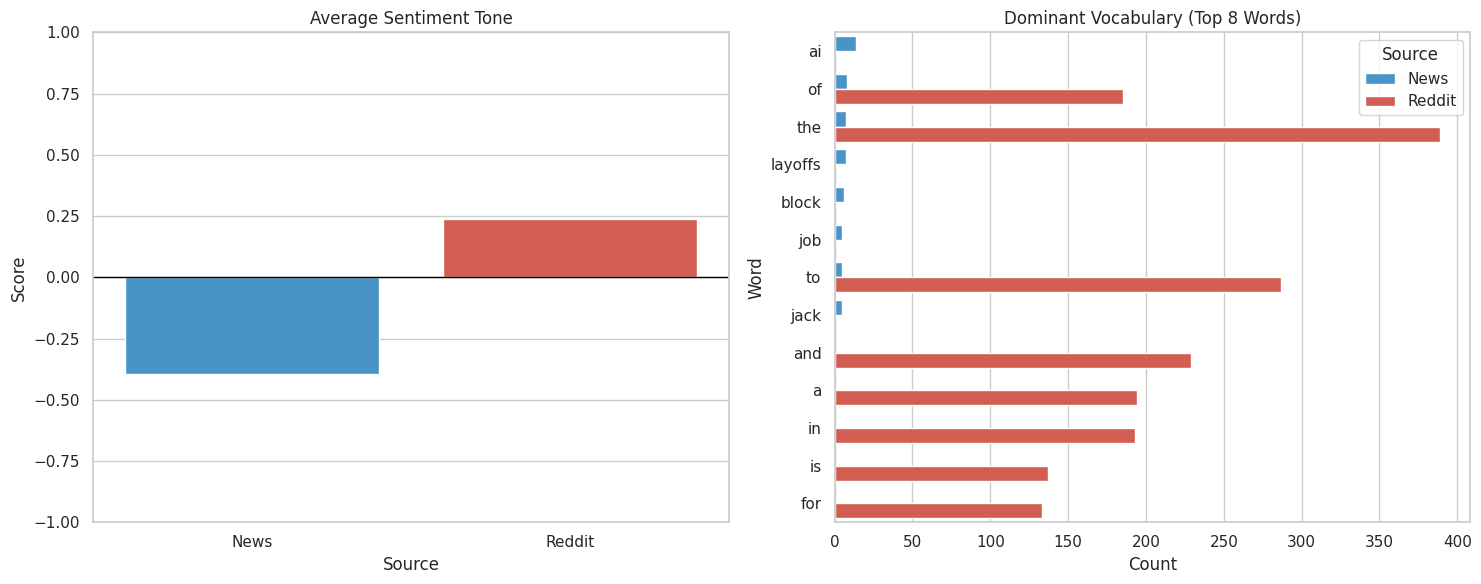


 RESEARCH TOPIC: UNIVERSAL BASIC INCOME
[ALIGNMENT] Cosine Similarity: 0.5293
[SENTIMENT] News: -0.05 | Reddit: +0.10
[THEMES]    News: ubi, ai, basic, universal, income
            Reddit: ai, people, universal, income, basic


/tmp/ipython-input-583/2857158095.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Source', y='Score', data=sent_df, ax=axes[0], palette=['#3498db', '#e74c3c'])


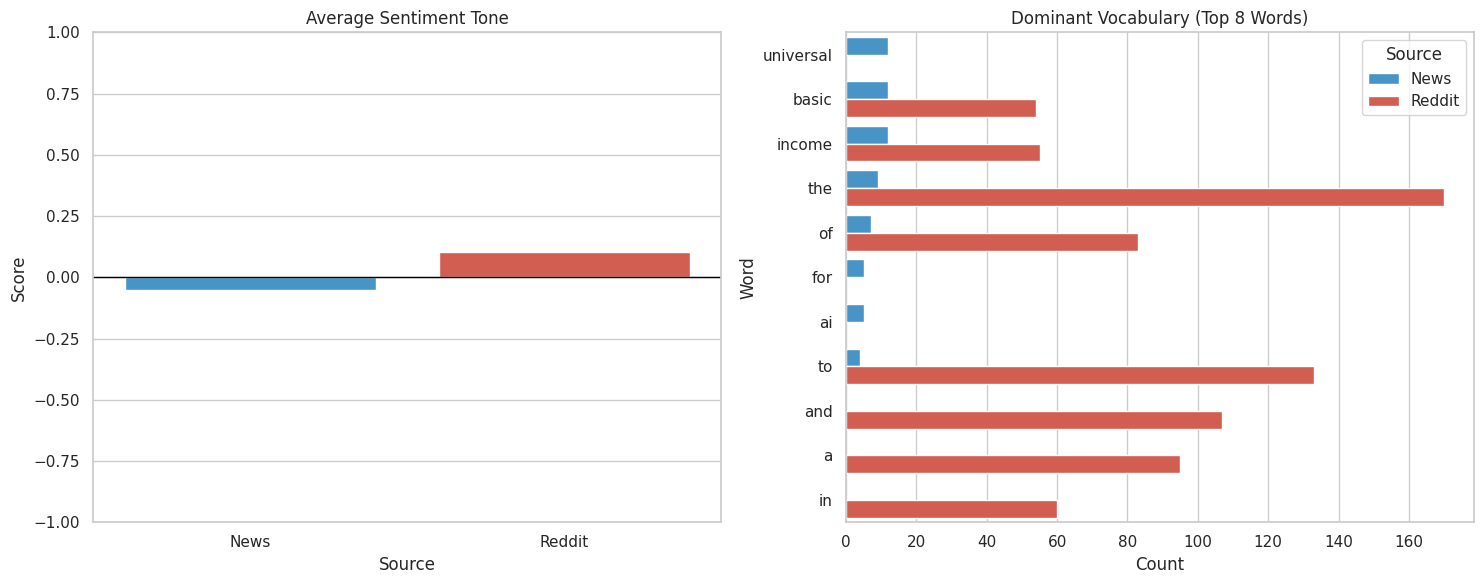


 RESEARCH TOPIC: NUCLEAR ENERGY
[ALIGNMENT] Cosine Similarity: 0.3794
[SENTIMENT] News: +0.04 | Reddit: +0.15
[THEMES]    News: iran, news, plant, power, nuclear
            Reddit: just, like, power, nuclear, energy


/tmp/ipython-input-583/2857158095.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Source', y='Score', data=sent_df, ax=axes[0], palette=['#3498db', '#e74c3c'])


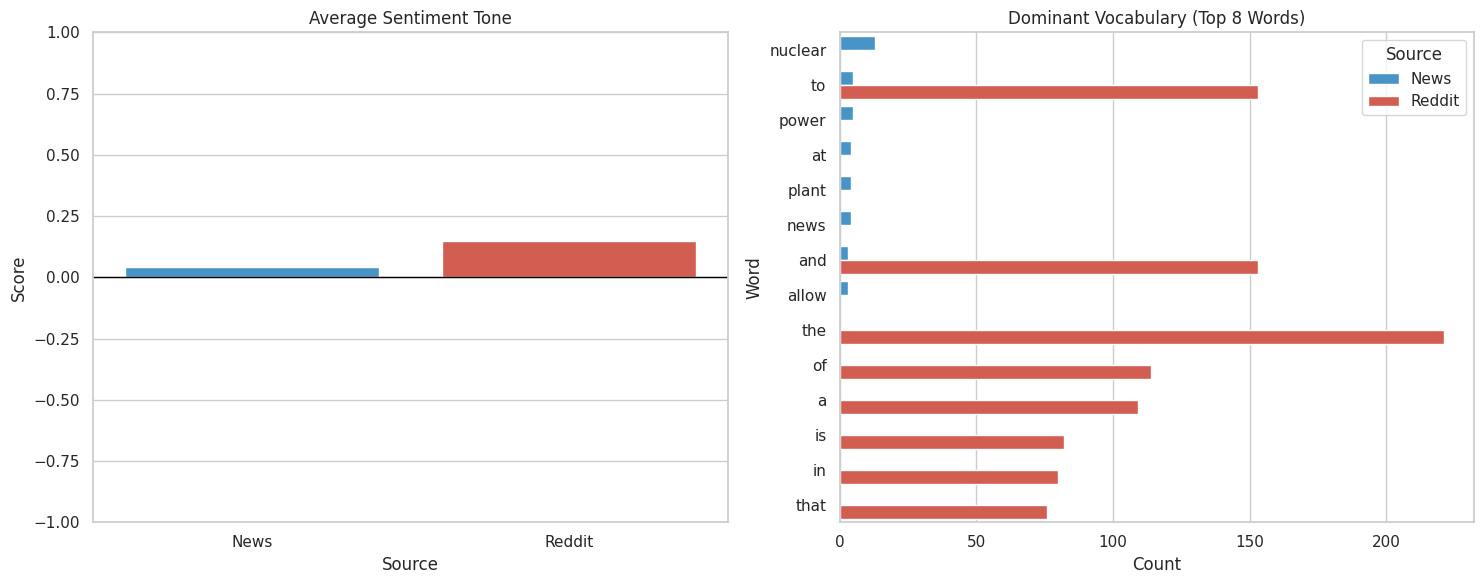


 RESEARCH TOPIC: CRYPTOCURRENCY REGULATION
[ALIGNMENT] Cosine Similarity: 0.2089
[SENTIMENT] News: -0.03 | Reddit: +0.29
[THEMES]    News: markets, cryptocurrency, global, regulation, crypto
            Reddit: bitcoin, regulations, crypto, regulation, cryptocurrency


/tmp/ipython-input-583/2857158095.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Source', y='Score', data=sent_df, ax=axes[0], palette=['#3498db', '#e74c3c'])


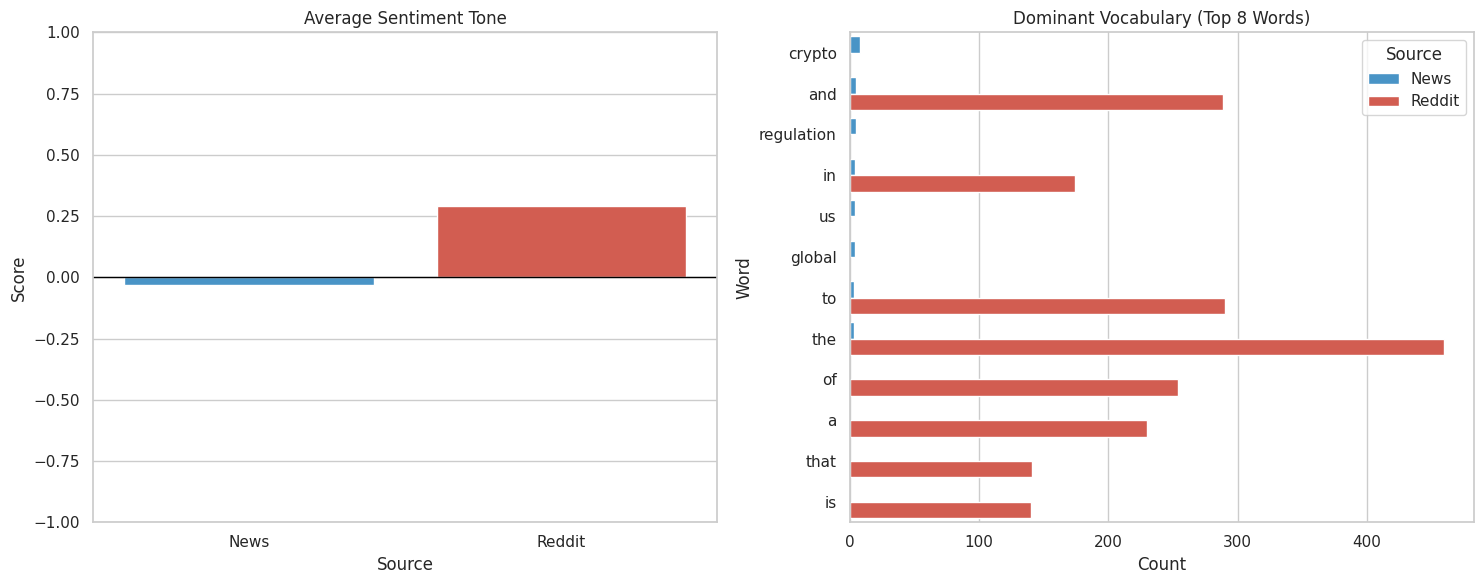


 RESEARCH TOPIC: SOCIAL MEDIA BAN
[ALIGNMENT] Cosine Similarity: 0.4126
[SENTIMENT] News: -0.34 | Reddit: -0.16
[THEMES]    News: under16s, teens, ban, media, social
            Reddit: banned, people, ban, media, social


/tmp/ipython-input-583/2857158095.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Source', y='Score', data=sent_df, ax=axes[0], palette=['#3498db', '#e74c3c'])


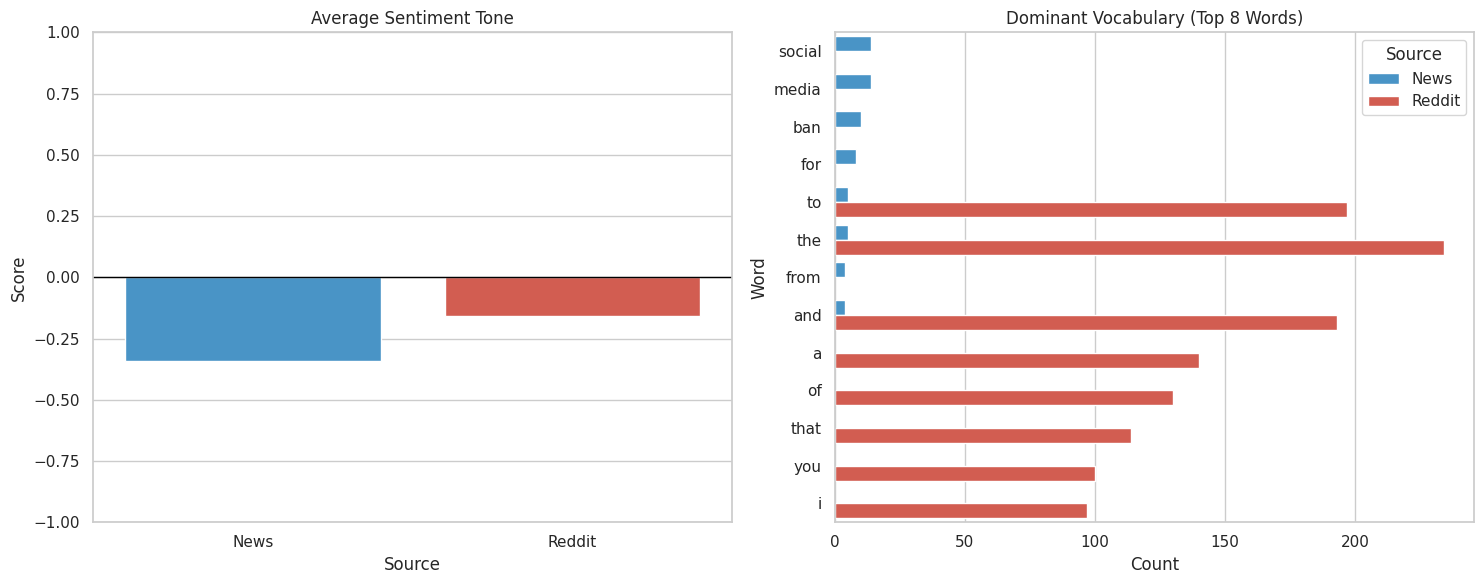

In [10]:
# --- MASTER CONSOLIDATED SCRIPT ---

def run_sentiment_analysis_with_viz(topic):
    print(f"\n{'='*70}")
    print(f" RESEARCH TOPIC: {topic.upper()}")
    print(f"{'='*70}")

    # 1. DATA COLLECTION
    encoded_q = urllib.parse.quote(topic)
    news_url = f"https://news.google.com/rss/search?q={encoded_q}"
    reddit_url = "https://api.pullpush.io/reddit/search/comment/"

    # Fetch News
    n_feed = feedparser.parse(news_url)
    n_raw = [clean_text(e.title) for e in n_feed.entries[:15]]

    # Fetch Reddit
    try:
        r_resp = requests.get(reddit_url, params={'q': topic, 'size': 50}, timeout=10)
        r_data = r_resp.json().get('data', [])
        r_raw = [clean_text(p.get('body', '')) for p in r_data if p.get('body')]
    except:
        r_raw = []

    # Validation: Ensure we have data to visualize
    if not n_raw or not r_raw:
        print(f"[!] Insufficient data for '{topic}'. skipping visualization.")
        return

    # 2. CALCULATE METRICS
    # Similarity
    vec = TfidfVectorizer(stop_words='english')
    tfidf = vec.fit_transform([" ".join(n_raw), " ".join(r_raw)])
    sim = cosine_similarity(tfidf[0:1], tfidf[1:2])[0][0]

    # Sentiment
    n_sents = [sia.polarity_scores(t)['compound'] for t in n_raw]
    r_sents = [sia.polarity_scores(t)['compound'] for t in r_raw]
    n_avg, r_avg = sum(n_sents)/len(n_sents), sum(r_sents)/len(r_sents)

    # 3. PRINT THE TEXT REPORT
    print(f"[ALIGNMENT] Cosine Similarity: {sim:.4f}")
    print(f"[SENTIMENT] News: {n_avg:+.2f} | Reddit: {r_avg:+.2f}")
    print(f"[THEMES]    News: {get_dominant_theme(n_raw)}")
    print(f"            Reddit: {get_dominant_theme(r_raw)}")

    # 4. GENERATE VISUALIZATION (Passing variables directly)
    sns.set_theme(style="whitegrid")
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    # Chart A: Sentiment Bars
    sent_df = pd.DataFrame({'Source': ['News', 'Reddit'], 'Score': [n_avg, r_avg]})
    sns.barplot(x='Source', y='Score', data=sent_df, ax=axes[0], palette=['#3498db', '#e74c3c'])
    axes[0].set_ylim(-1, 1)
    axes[0].set_title("Average Sentiment Tone")
    axes[0].axhline(0, color='black', lw=1)

    # Chart B: Keyword Frequency (The "Why")
    n_words = Counter(" ".join(n_raw).split()).most_common(8)
    r_words = Counter(" ".join(r_raw).split()).most_common(8)

    # Process for plotting
    words_data = []
    for w, c in n_words: words_data.append({'Word': w, 'Count': c, 'Source': 'News'})
    for w, c in r_words: words_data.append({'Word': w, 'Count': c, 'Source': 'Reddit'})

    word_df = pd.DataFrame(words_data)
    sns.barplot(x='Count', y='Word', hue='Source', data=word_df, ax=axes[1], palette=['#3498db', '#e74c3c'])
    axes[1].set_title("Dominant Vocabulary (Top 8 Words)")

    plt.tight_layout()
    plt.show()

# --- RUN THE ANALYSIS ---
high_variance_topics = [
    "ai related layoffs",
    "universal basic income",
    "nuclear energy",
    "cryptocurrency regulation",
    "social media ban"
]

for t in high_variance_topics:
    run_sentiment_analysis_with_viz(t)
    time.sleep(2)

Let's clean up the unimportant words displayed in the vizualization above.


 ANALYSIS: AI RELATED LAYOFFS


/tmp/ipython-input-583/3057423136.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['News', 'Reddit'], y=[n_avg, r_avg], ax=axes[0], palette=['#3498db', '#e74c3c'])


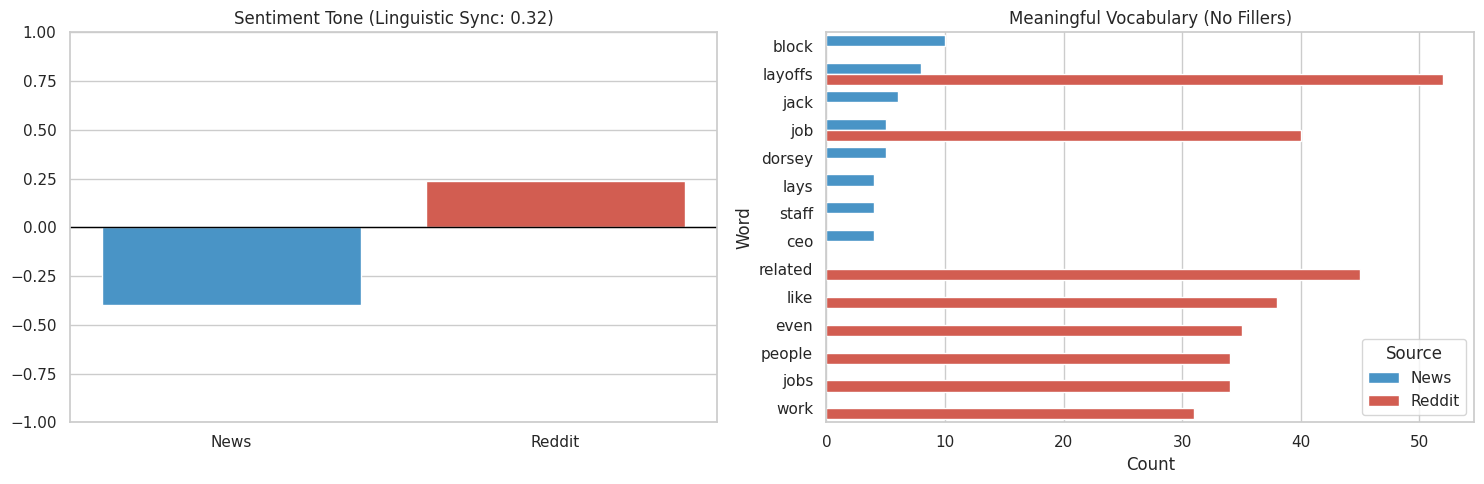


 ANALYSIS: UNIVERSAL BASIC INCOME


/tmp/ipython-input-583/3057423136.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['News', 'Reddit'], y=[n_avg, r_avg], ax=axes[0], palette=['#3498db', '#e74c3c'])


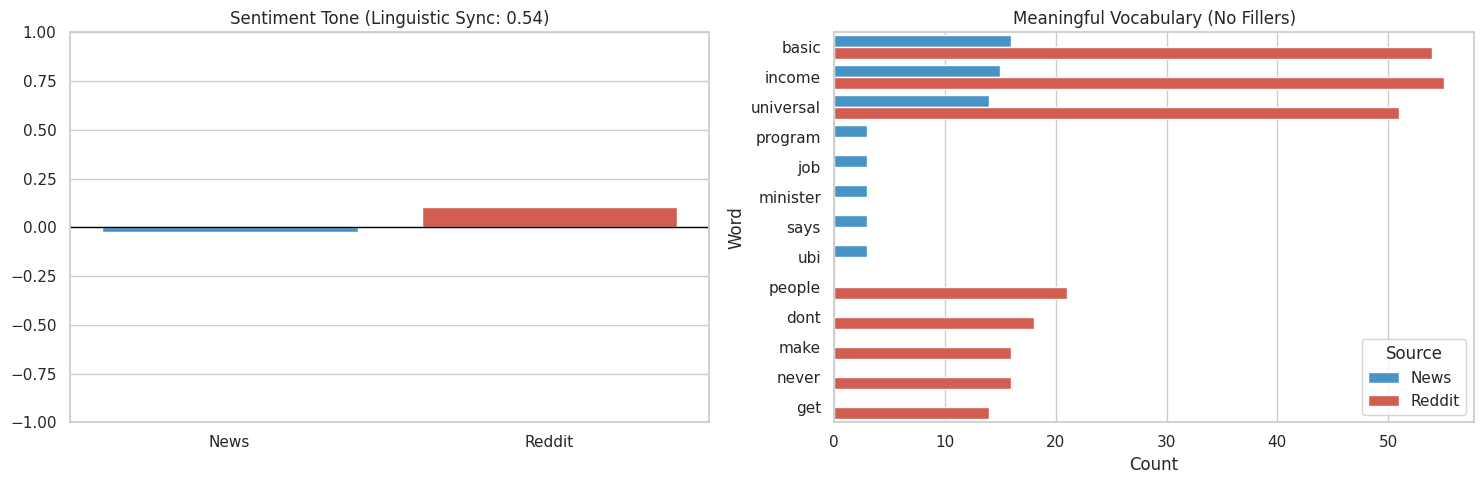


 ANALYSIS: NUCLEAR ENERGY


/tmp/ipython-input-583/3057423136.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['News', 'Reddit'], y=[n_avg, r_avg], ax=axes[0], palette=['#3498db', '#e74c3c'])


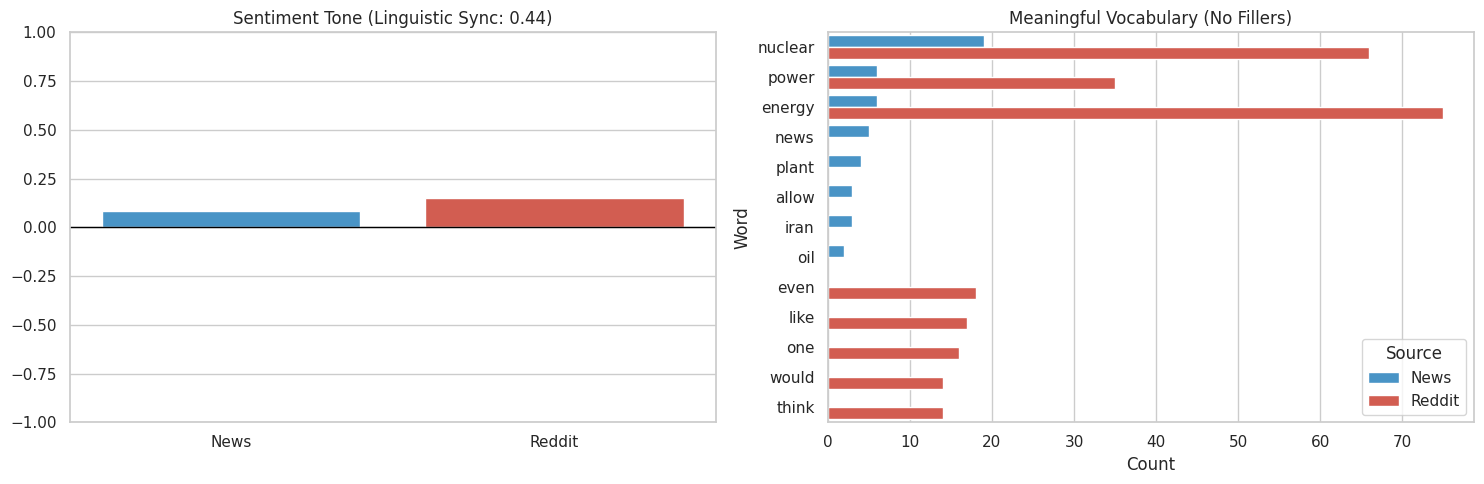


 ANALYSIS: CRYPTOCURRENCY REGULATION


/tmp/ipython-input-583/3057423136.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['News', 'Reddit'], y=[n_avg, r_avg], ax=axes[0], palette=['#3498db', '#e74c3c'])


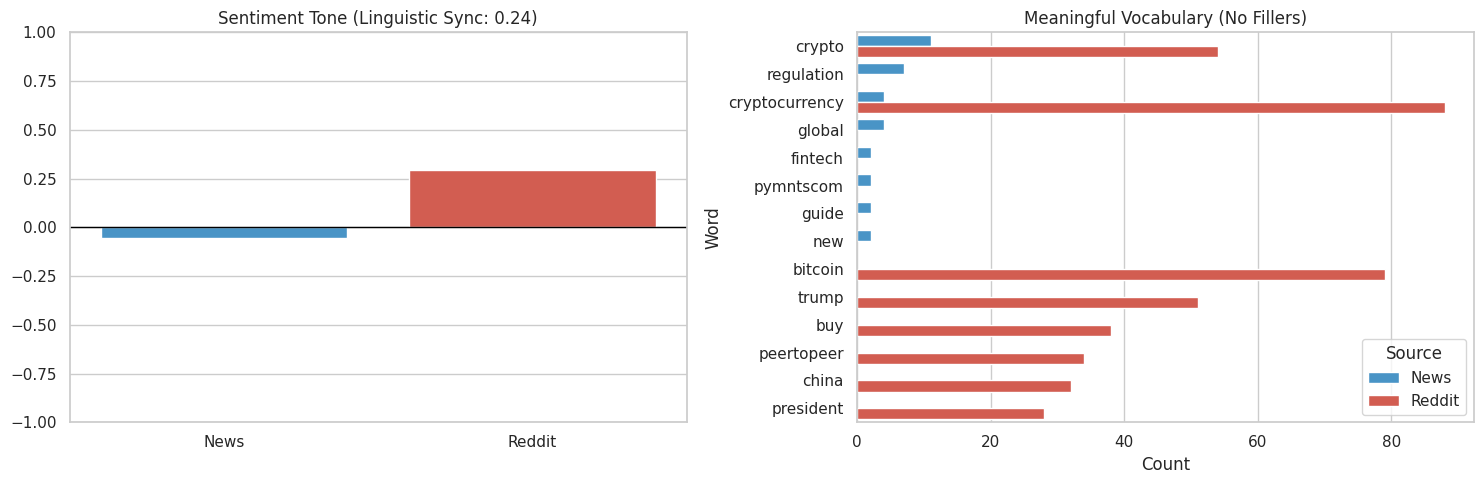


 ANALYSIS: SOCIAL MEDIA BAN


/tmp/ipython-input-583/3057423136.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['News', 'Reddit'], y=[n_avg, r_avg], ax=axes[0], palette=['#3498db', '#e74c3c'])


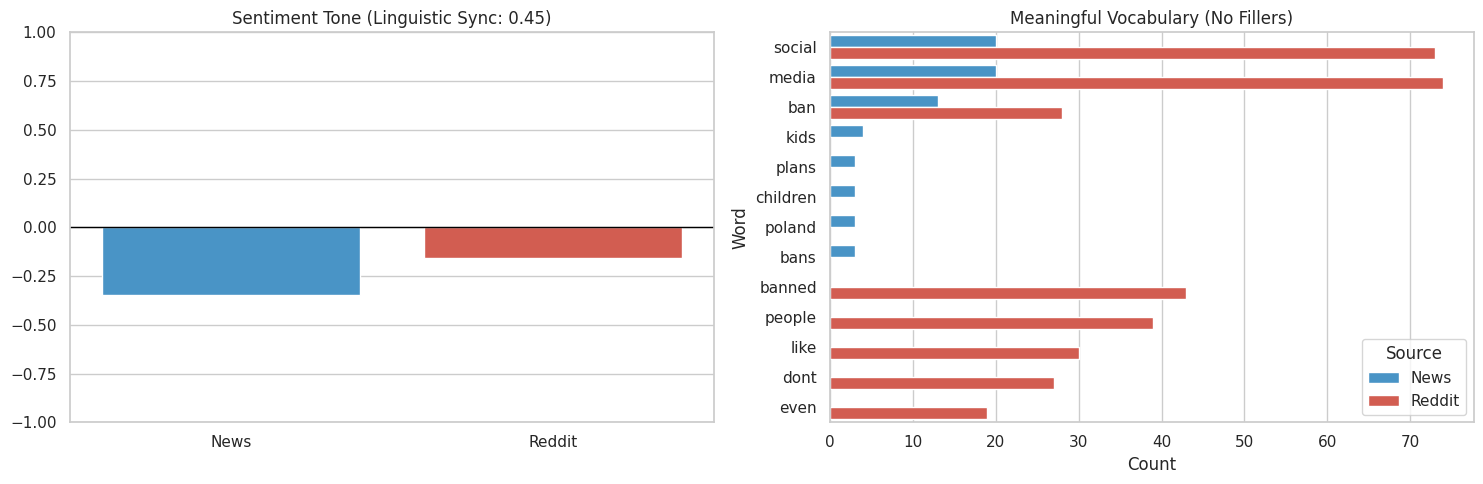

In [11]:
# --- NEW CELL: UPDATED CLEANING & VISUALIZATION ---
import nltk
from nltk.corpus import stopwords

# 1. Update the Filter List
nltk.download('stopwords', quiet=True)
base_stop_words = set(stopwords.words('english'))
# Adding the specific filler words you identified
custom_fillers = {'they', 'it', 'to', 'you', 'that', 'this', 'for', 'with', 'from', 'have', 'was', 'the', 'and', 'but', 'not', 'are', 'is', 'your'}
all_stop_words = base_stop_words.union(custom_fillers)

def get_meaningful_words(text_list, limit=10):
    """Filters out stop words and short filler words for the charts."""
    all_words = " ".join(text_list).lower().split()
    # Filter: Not a stopword, length > 2, and contains only letters
    meaningful = [w for w in all_words if w not in all_stop_words and len(w) > 2 and w.isalpha()]
    return Counter(meaningful).most_common(limit)

# 2. Redefine the main function with the new filters
def run_sentiment_analysis_with_viz(topic):
    print(f"\n{'='*70}\n ANALYSIS: {topic.upper()}\n{'='*70}")

    # --- Data Collection (Re-using logic from previous cell) ---
    encoded_q = urllib.parse.quote(topic)
    n_feed = feedparser.parse(f"https://news.google.com/rss/search?q={encoded_q}")
    n_raw = [clean_text(e.title) for e in n_feed.entries[:20]]

    try:
        r_resp = requests.get("https://api.pullpush.io/reddit/search/comment/",
                              params={'q': topic, 'size': 50}, timeout=10)
        r_raw = [clean_text(p.get('body', '')) for p in r_resp.json().get('data', [])]
    except: r_raw = []

    if not n_raw or not r_raw: return print(f"Skipping {topic} - no data.")

    # --- Calculations ---
    tfidf = TfidfVectorizer(stop_words='english').fit_transform([" ".join(n_raw), " ".join(r_raw)])
    sim = cosine_similarity(tfidf[0:1], tfidf[1:2])[0][0]
    n_avg = sum([sia.polarity_scores(t)['compound'] for t in n_raw]) / len(n_raw)
    r_avg = sum([sia.polarity_scores(t)['compound'] for t in r_raw]) / len(r_raw)

    # --- Visuals ---
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # Sentiment Bar
    sns.barplot(x=['News', 'Reddit'], y=[n_avg, r_avg], ax=axes[0], palette=['#3498db', '#e74c3c'])
    axes[0].set_ylim(-1, 1)
    axes[0].set_title(f"Sentiment Tone (Linguistic Sync: {sim:.2f})")
    axes[0].axhline(0, color='black', lw=1)

    # CLEANED Keyword Bar
    n_words = get_meaningful_words(n_raw, 8)
    r_words = get_meaningful_words(r_raw, 8)
    word_df = pd.DataFrame([{'Word': w, 'Count': c, 'Source': 'News'} for w, c in n_words] +
                           [{'Word': w, 'Count': c, 'Source': 'Reddit'} for w, c in r_words])

    sns.barplot(x='Count', y='Word', hue='Source', data=word_df, ax=axes[1], palette=['#3498db', '#e74c3c'])
    axes[1].set_title("Meaningful Vocabulary (No Fillers)")
    plt.tight_layout()
    plt.show()

# 3. Run the analysis with the new high-variance list
high_variance_topics = [
    "ai related layoffs",
    "universal basic income",
    "nuclear energy",
    "cryptocurrency regulation",
    "social media ban"
]

for t in high_variance_topics:
    run_sentiment_analysis_with_viz(t)
    time.sleep(2)